# Lab 4 Presentation - First Competition Round-Up

Erez Buchweitz

# How was the competition for you?

Hard? Entertaining? Stressful? Fun?

What did you learn?

What prevented you from showing your true self?

What are you going to do better next time?

# Where we’re at

Regression:

-   ~~OLS, ridge, lasso, elastic net (Unit 1)~~
-   Random forests, gradient boosting (Unit 6)
-   (Deep learning)
-   Kernel methods (Unit 5)

Classification (Unit 3)

Unsupervised learning (Unit 4)

More topics:

-   ~~Complexity - bias-variance decomposition, VC dimension (Unit 2)~~
-   Cross validation (Unit 2)
-   Computation (Unit 6)
-   (Conformal prediction)

# Was there noise in the data?

Noise in a linear model can come in (at least) three forms:

1.  Inherent unpredictability: $$
    y = \beta_1 x_1 + \varepsilon
    $$
2.  Missing features: $$
    y = \beta_1 x_1 + \beta_2 x_2
    $$
3.  Model misspecification: $$
    y = f(x_1)
    $$

Comments:

-   Examples of the innovative sources of information: President Trump’s
    tweets, or pizza delivery traffic near Pentagon
-   The first and second kind are virtually indistinguishable. Some
    statisticians even claim that the first kind does not exist

The data in the first competition had only the third kind of noise. It
was possible to reach zero loss.

# Bias-variance decomposition

Recall from the lecture: $$
\mathbb{E}_{\,}\left[\left(y-\hat f(\boldsymbol{x})\right)^2|\boldsymbol{x}\right] = \text{Var}\left(y|\boldsymbol{x}\right) + \left(\mathbb{E}_{\,}\left[y|\boldsymbol{x}\right] - \mathbb{E}_{\,}\left[\hat f(\boldsymbol{x})|\boldsymbol{x}\right]\right)^2 + \text{Var}\left(\hat f(\boldsymbol{x})|\boldsymbol{x}\right),
$$ where $\hat f$ (model trained on training set) is independent of
$y, \boldsymbol{x}$ (test observation).

-   The first component is inaccurately referred to as the irreducible
    error. It would be accurate to say that it is irreducible given the
    features we currently have, but we may always acquire new features.
-   The second component is the bias.
-   The third component is the variance.

## Bias-variance tradeoff

It was commonly thought that bias and variance play off of each other in
the following way:

(U-shaped plot where x axis is model complexity, y axis is expected test
error)

-   Low complexity –\> high bias, low variance
-   High complexity –\> low bias, high variance

The game is to control both bias and variance in order to find the sweet
spot in the middle which obtains least error.

-   Most commonly used models (notable exception: deep learning) play
    off on this tradeoff. They offer different kinds of tradeoff curves
    that you can minimize
-   Statisticians and computer scientists used to think this was the
    entire game, but then deep learning came

Deep learning extends the line further right, to extremely high
complexity, and the curve drops again (this is called double descent).
This regime went overlooked before. Now we say that the U-shape is
called the underparameterized regime, compared to the overparameterized
regime to its right.

-   Since we decided not to teach deep learning this semester, we will
    not focus on overparameterized learning
-   The bias-variance decomposition is a mathematical fact, it remains
    true in the overparameterized regime. But the interpretation of
    trading off bias and variance to find the sweet spot is restricted
    to the underparameterized regime, which is pretty much any other
    model beside deep learning. And those are widely used in practice in
    industry and academia

## Controlling bias and variance in the underparameterized regime

Two archtypical methods:

1.  Parsimonious approach

    Start from a low-complexity model with high bias and low variance,
    and start increasing complexity. In terms of complexity of function
    classes, you use a small function class.

    Example: gradient boosting

2.  Expressive + regularization approach

    Start from a high-complexity model with low bias and high variance,
    and use regularization to control complexity. In terms of complexity
    function classes, you use a (too) big function class, but you look
    through it restrictively.

    Example: random forest

# Back to the first competition

The two approaches were widely represented in the solutions you
submitted:

-   Parsimonious - start with OLS on the original raw features, engineer
    new features manually via exploration, adding only a handful of
    features to the final model
-   Expressive - start by immediately adding tons of polynomial or
    spline features, tone down using ridge or lass

The two top scoring teams:

-   One used the expressive approach
-   One used a hybrid between the two approaches - engineer new features
    manually via exploration, then on top of it add many transformations

We’ll now go over each of the two winning approaches, and then we’ll go
over how a parsimonious would approach the data

## Load data

In [83]:
import numpy as np

X_train = np.load(r"..\datasets\competition_1_linear_regression\X_train.npy")
y_train = np.load(r"..\datasets\competition_1_linear_regression\y_train.npy")
X_test = np.load(r"..\datasets\competition_1_linear_regression\X_test.npy")
y_test = np.load(r"..\datasets\competition_1_linear_regression\y_test.npy")

def squared_error(y, pred):
    err = (y - pred) ** 2
    return {
        "avg": np.mean(err),
        "se": np.std(err) / np.sqrt(err.shape[0])
    }

# Expressive approach - splines and lasso

In [84]:
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

model_expressive = make_pipeline(
    PolynomialFeatures(degree=2),
    SplineTransformer(n_knots=10),
    StandardScaler(),
    Lasso(alpha=0.01)
)

model_expressive.fit(X_train, y_train)
pred_expressive = model_expressive.predict(X_test)

squared_error(y_test, pred_expressive)

{'avg': 0.982071777758838, 'se': 0.031203585216418275}

This team:

-   Made zeroth-, first- and second-degree polynomials of the raw
    features (including interactions)
-   On top of those features added third-degree splines with ten knots
-   Standardized the features to have average zero and standard
    deviation one, and the target to have average zero

## Number of parameters

In [85]:
coef = model_expressive.named_steps["lasso"].coef_
print(f"num features: {coef.shape[0]}")
print(f"num nonzero features: {np.sum(coef != 0)}")

num features: 792
num nonzero features: 231

This approach requires serious hyperparameter optimization. The
hyperparameters are at least those:

-   Polynomial degree
-   Spline degree
-   Spline knots
-   Lasso penalty

Using arbitrary values for these hyperparameters will lead to very bad
loss. This team managed to find combinations of these parameters that
lead to very low loss.

-   The first three parameters increase complexity
-   The fourth parameter tones down complexity

Therefore there is an interplay between the parameters and they have to
be tuned together.

## Lasso penalty

In [86]:
lasso_alphas = 10**np.linspace(-5, 5, 20)
losses = []
num_nonzero = []
for alpha in lasso_alphas:
    model = make_pipeline(
        PolynomialFeatures(degree=2),
        SplineTransformer(degree=3, n_knots=10),
        StandardScaler(),
        Lasso(alpha=alpha)
    )

    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    losses.append(squared_error(y_test, pred)["avg"])
    
    coef = model.named_steps["lasso"].coef_
    num_nonzero.append(np.sum(coef != 0))

c:\Users\erezm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.787e+03, tolerance: 1.059e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\erezm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.543e+03, tolerance: 1.059e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\erezm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

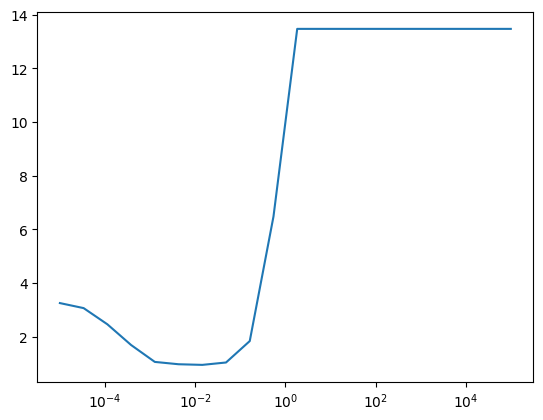

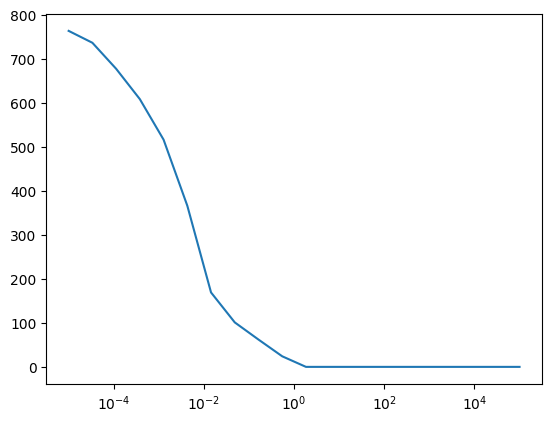

In [87]:
from matplotlib import pyplot as plt

plt.plot(lasso_alphas, losses)
plt.xscale("log")
plt.show()
plt.plot(lasso_alphas, num_nonzero)
plt.xscale("log")

The first plot is the loss according the (log10 of) lasso penalty. We
can see the sweet spot is 0.01.

The second plot is the number of nonzero features. We can see that the
number of nonzero features drops to zero when the penalty is large
enough

## Interplay between expressiveness and regularization

In [134]:
lasso_alphas = 10**np.linspace(-5, -1, 10)
spline_knots = [2,5,7,10]
losses = []
for alpha in lasso_alphas:
    for knots in spline_knots:
        model = make_pipeline(
            PolynomialFeatures(degree=2),
            SplineTransformer(n_knots=knots),
            StandardScaler(),
            Lasso(alpha=alpha)
        )

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        losses.append((alpha, knots, squared_error(y_test, pred)["avg"]))

import pandas as pd
losses_df = pd.DataFrame(losses)
losses_df.columns = ["alpha", "knots", "loss"]

c:\Users\erezm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.557e+03, tolerance: 1.059e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\erezm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.536e+03, tolerance: 1.059e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\erezm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

c:\Users\erezm\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\erezm\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\erezm\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

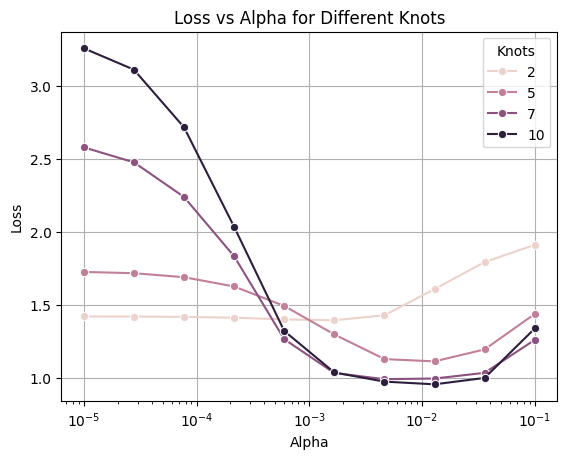

In [135]:
import seaborn as sns

sns.lineplot(data=losses_df[losses_df.alpha <= 0.5], x="alpha", y="loss", hue="knots", marker="o")
plt.xscale("log")

# Labels and title
plt.xlabel("Alpha")
plt.ylabel("Loss")
plt.title("Loss vs Alpha for Different Knots")
plt.legend(title="Knots")
plt.grid(True)
plt.show()

# Hybrid approach - manually adding many features and ridge

In [90]:
from sklearn.linear_model import RidgeCV


def engineer_data(X):
    hand = np.column_stack([
        (X[:, 3] < 0).astype(int),
        ((0 <= X[:, 3]) & (X[:, 3] < 1)).astype(int),
        (X[:, 3] >= 1).astype(int),
    ])

    interactions = np.array([
        X[:, i] * X[:, j]
        for i in range(X.shape[1])
        for j in range(X.shape[1])
    ]).T

    cubes = np.apply_along_axis(lambda x: x**3, 0, X)
    exps = np.apply_along_axis(np.exp, 0, X)
    sqrts = np.apply_along_axis(lambda x: np.sqrt(np.abs(x)), 0, X)

    return np.hstack([X, hand, interactions, cubes, exps, sqrts])
    

engineered_X_train, engineered_X_test = map(engineer_data, (X_train, X_test))

model_parsimonious = RidgeCV(alphas=10**np.linspace(-1, 1, 20), store_cv_results=True)
model_parsimonious.fit(engineered_X_train, y_train)

pred_parsimonious = model_parsimonious.predict(engineered_X_test)

squared_error(y_test, pred_parsimonious)

{'avg': 1.0316155775477391, 'se': 0.026829800534337613}

This team made:

-   A one-hot representation for a particular feature (X3)
-   Added all second-degree polynomials of the raw features (including
    interactions)
-   Added all cubic, exponential and square root transformations of each
    raw feature
-   Fit ridge with parameter selected by cross validation

The loss is:

-   Not as good as the other team
-   But within two standard errors of each other. So it’s hard to say
    which approach is actually better

## Number of features

In [91]:
print(f"num features: {engineered_X_train.shape[1]}")

num features: 143

## Ridge penalty

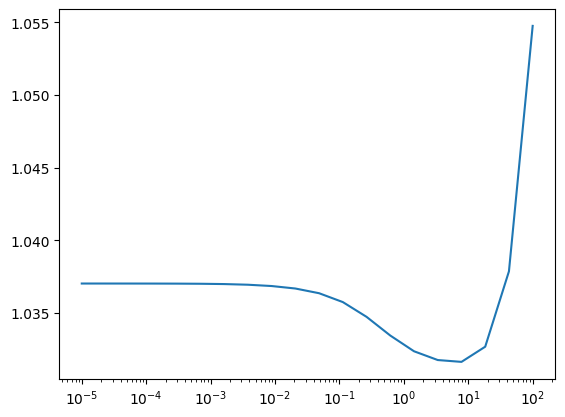

In [92]:
from sklearn.linear_model import Ridge

ridge_alphas = 10**np.linspace(-5, 2, 20)
losses = []
for alpha in ridge_alphas:
    model = Ridge(alpha=alpha)
    model.fit(engineered_X_train, y_train)
    pred = model.predict(engineered_X_test)
    losses.append(squared_error(y_test, pred)["avg"])

plt.plot(ridge_alphas, losses)
plt.xscale("log")


## What if lasso was used?

c:\Users\erezm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.952e+03, tolerance: 1.059e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\erezm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.909e+03, tolerance: 1.059e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\erezm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

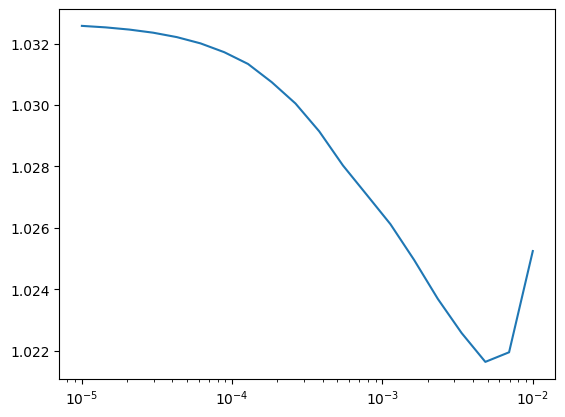

In [93]:
lasso_alphas = 10**np.linspace(-5, -2, 20)
losses = []
for alpha in lasso_alphas:
    model = Lasso(alpha=alpha)
    model.fit(engineered_X_train, y_train)
    pred = model.predict(engineered_X_test)
    losses.append(squared_error(y_test, pred)["avg"])

plt.plot(lasso_alphas, losses)
plt.xscale("log")

We can see that lasso would have slightly improved the predictions.

## Deep dive into feature X3

This team transformed it into a one-hot encoding representing a step
function

In [94]:
def quantile_plot(x, y, by=None, bins=10, by_bins=3, y_fn=np.mean):
    assert len(x) == len(y)

    def qp_data(x, y):
        fac = np.searchsorted(np.quantile(x, q=[i / bins for i in range(1, bins)]), x)
        ufac = np.unique(fac)
        qx = np.array([np.mean(x[fac == f]) for f in ufac])
        qy = np.array([y_fn(y[fac == f]) for f in ufac])
        return qx, qy

    qx, qy = qp_data(x, y)
    if by is None:
        plt.plot(qx, qy, "-o")
    else:
        assert len(x) == len(by)
        plt.plot(qx, qy, "-o", label="ALL", color="lightgrey")
        by_fac = np.searchsorted(np.quantile(by, q=[i / by_bins for i in range(1, by_bins)]), by)
        by_ufac = np.unique(by_fac)
        for i, f in enumerate(np.unique(by_ufac)):
            mask = by_fac == f
            nm = f"{i}) {min(by[mask]):.2f} / {max(by[mask]):.2f}"
            qx, qy = qp_data(x[mask], y[mask])
            plt.plot(qx, qy, "-o", label=nm)
        plt.legend()

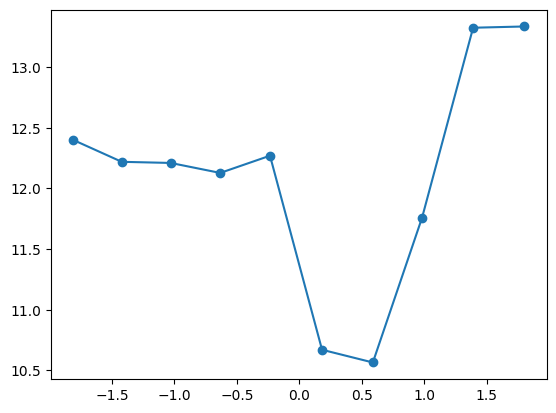

In [95]:
quantile_plot(X_train[:,3], y_train)

Is this a step function? Let’s increase the number of bins, increasing
granularity but also making the plot more noisy because there are less
observations in each bin

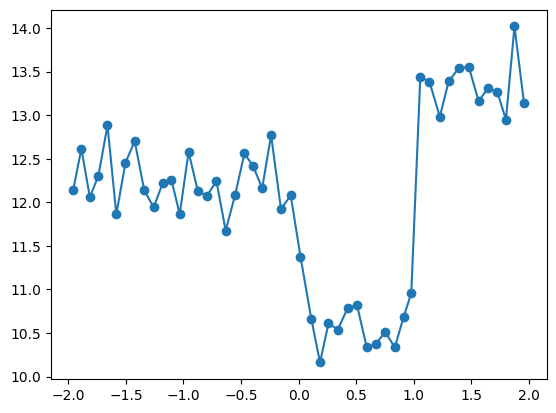

In [96]:
quantile_plot(X_train[:,3], y_train, bins=50)

-   Looks like the local variabilty in each of three regions is smaller
    than the differences between the regions
-   It seems reasonable to assume at this point that there are three
    distinct regions with different behaviors
-   Is it reasonable to assume the function is constant in each region,
    like this team did?
-   I would say that at least this would be a reasonable approximation

# Ensembling

We will now average the predictions of the two teams, and voila:

In [97]:
pred_combined = (pred_expressive + pred_parsimonious) / 2
squared_error(y_test, pred_combined)

{'avg': 0.9016597970552396, 'se': 0.023160191674497673}

-   The test score has declined and it is now three standard deviations
    below the previous top score
-   This is known as ensembling. Nowadays its rare to find a Kaggle
    winner that did not use ensembling between different methods

## Why does ensembling work?

*Claim.* If $\hat Y_1$ and $\hat Y_2$ are independent unbiased
estimators of $y$, then $(\hat Y_1 + \hat Y_2)/2$ is an unbiased
estimator of $y$ and $$
\text{Var}\left(\frac{\hat Y_1 + \hat Y_2}{2}\right) = \frac{\text{Var}\left(\hat Y_1\right) + \text{Var}\left(\hat Y_2\right)}{4}.
$$

-   Thus, if
    $\max\left(\text{Var}\left(\hat Y_1\right), \text{Var}\left(\hat Y_2\right)\right) < 3\cdot \min\left(\text{Var}\left(\hat Y_1\right), \text{Var}\left(\hat Y_2\right)\right)$,
    then
    $\text{Var}\left(\frac{\hat Y_1 + \hat Y_2}{2}\right) < \min\left(\text{Var}\left(\hat Y_1\right), \text{Var}\left(\hat Y_2\right)\right)$.
-   If the variances are similar, the averaged estimator has lower
    variance than each individual estimator
-   By the bias-variance decomposition, it achieved lower expected test
    loss!
-   If the variances are not similar, for example if one estimator is
    very clean (low variance) and the other is very noisy, averaging
    them will contaminate the clean estimator and won’t result in
    improvement over the clear estimator
-   In that case, you can always get a better averaged estimator than
    each individual estimator by averaging with unequal weights
    (i.e. putting less weight on the noisy one)

## Ensembling is a method of reducing variance

Example of model that inherently does ensembling: random forest.

## Question: do we have any reason to believe the two predictions are independent or unbiased?

-   No. But they’re using different methods, so we might guess that they
    are “not very biased” and “not too dependent”.
-   Then we try and see if it worked, by computing loss on a validation
    set

# Looking into the data (parsimonious approach)

## Split training data into two:

In [98]:
Xa, ya = X_train[:6000,:], y_train[:6000]
Xb, yb = X_train[6000:,:], y_train[6000:]

In [99]:
def OLS(X, y):
    return np.linalg.inv(X.T @ X) @ (X.T @ y)

def transform(X, feature_maps):
    return np.array([f(X) for f in feature_maps]).T

def fit_and_evaluate(Xa, ya, Xb, yb, feature_maps):
    b = OLS(transform(Xa, feature_maps), ya)
    pred = transform(Xb, feature_maps) @ b
    return squared_error(yb, pred)["avg"]

In [100]:
feature_maps = [lambda X: np.ones(X.shape[0])]

fit_and_evaluate(Xa, ya, Xb, yb, feature_maps)

13.039256026455085

# Start exploring

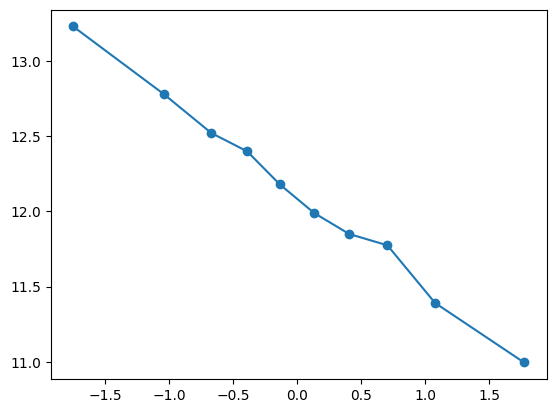

In [101]:
quantile_plot(Xa[:,0], ya)

In [102]:
feature_maps.append(lambda X: X[:,0])

fit_and_evaluate(Xa, ya, Xb, yb, feature_maps)

12.69371546643529

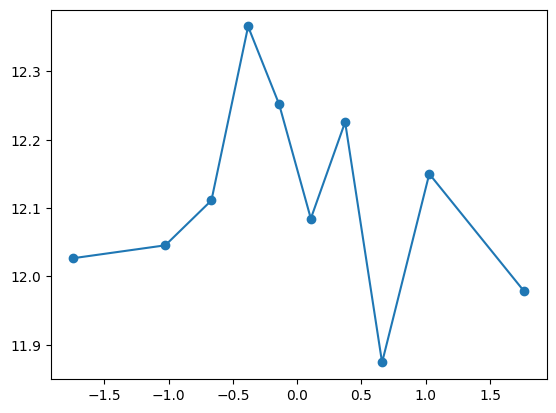

In [103]:
quantile_plot(Xa[:,1], ya)

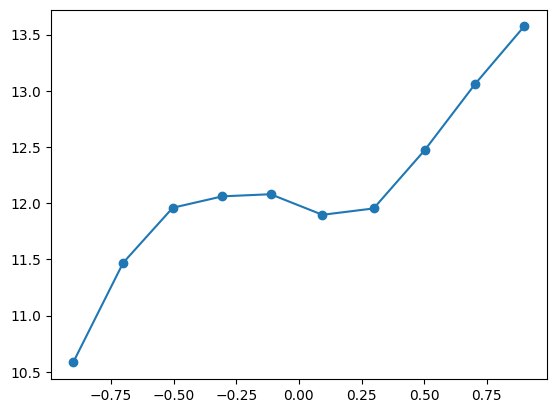

In [104]:
quantile_plot(Xa[:,2], ya)

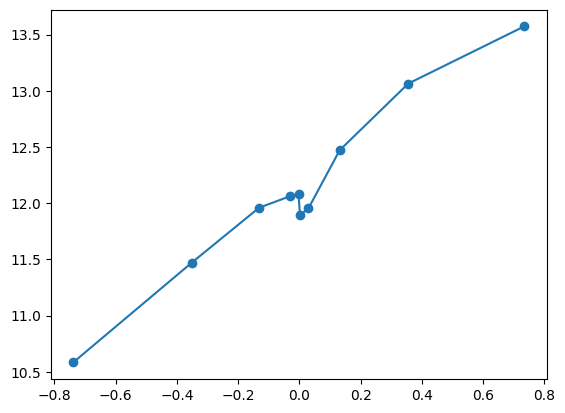

In [105]:
quantile_plot(Xa[:,2] ** 3, ya)

In [106]:
feature_maps.append(lambda X: X[:,2] ** 3)

fit_and_evaluate(Xa, ya, Xb, yb, feature_maps)

12.016124664896074

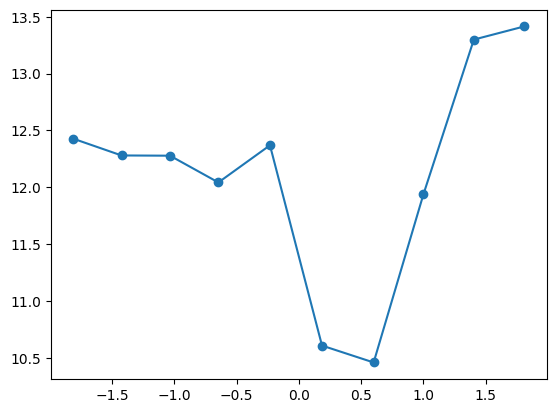

In [107]:
quantile_plot(Xa[:,3], ya)

In [108]:
feature_maps.append(lambda X: X[:,3] <= 0)
feature_maps.append(lambda X: X[:,3] > 1)

fit_and_evaluate(Xa, ya, Xb, yb, feature_maps)

11.08758042106949

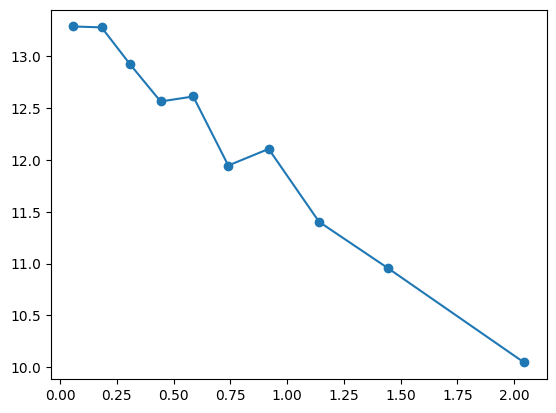

In [109]:
quantile_plot(Xa[:,4], ya)

In [110]:
feature_maps.append(lambda X: X[:,4])

fit_and_evaluate(Xa, ya, Xb, yb, feature_maps)

10.237321352723928

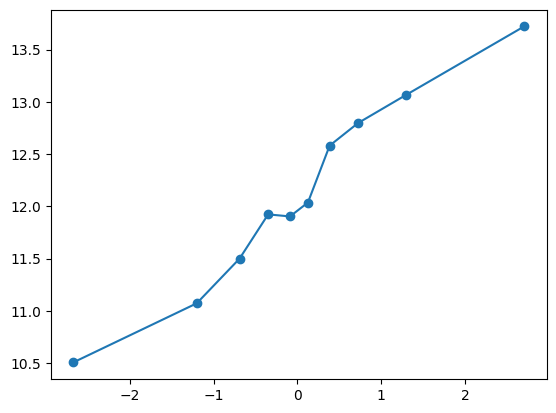

In [111]:
quantile_plot(Xa[:,5], ya)

In [112]:
feature_maps.append(lambda X: X[:,5])

fit_and_evaluate(Xa, ya, Xb, yb, feature_maps)

9.517495255911795

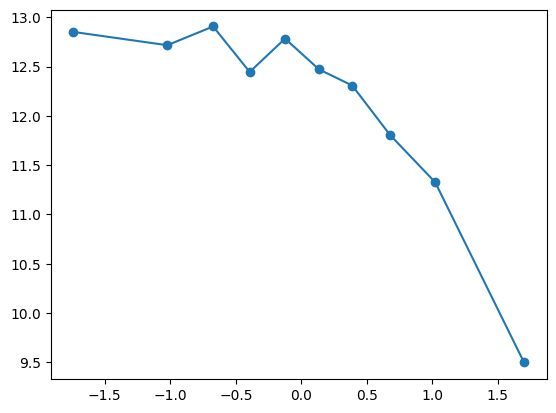

In [113]:
quantile_plot(Xa[:,6], ya)

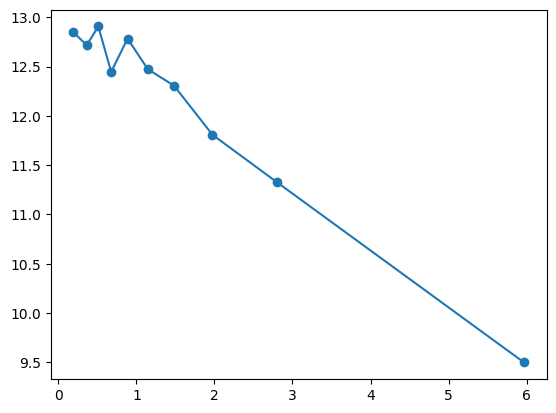

In [114]:
quantile_plot(np.exp(Xa[:,6]), ya)

In [115]:
feature_maps.append(lambda X: np.exp(X[:,6]))

fit_and_evaluate(Xa, ya, Xb, yb, feature_maps)

7.9719145561490095

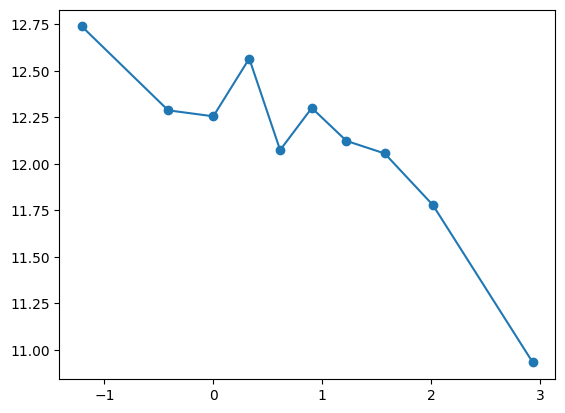

In [116]:
quantile_plot(Xa[:,7], ya)

Unclear what appropriate transformation, try including as is

In [117]:
feature_maps.append(lambda X: X[:,7])

fit_and_evaluate(Xa, ya, Xb, yb, feature_maps)

7.958626495914741

Loss didn’t improve significantly! Something’s wrong. Perhaps
contribution of X7 already included in previous features

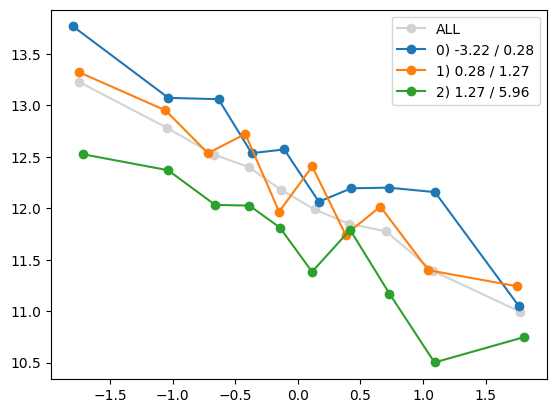

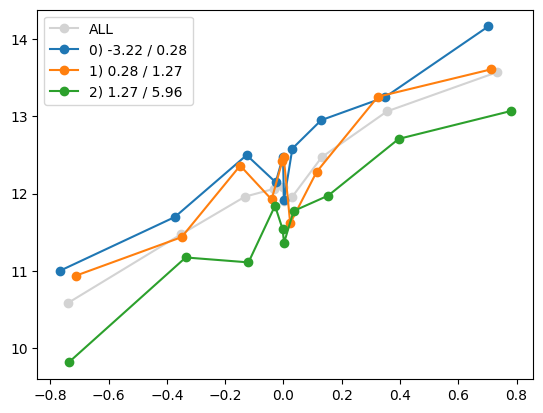

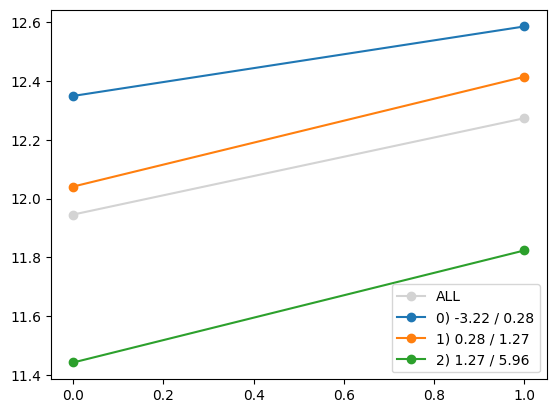

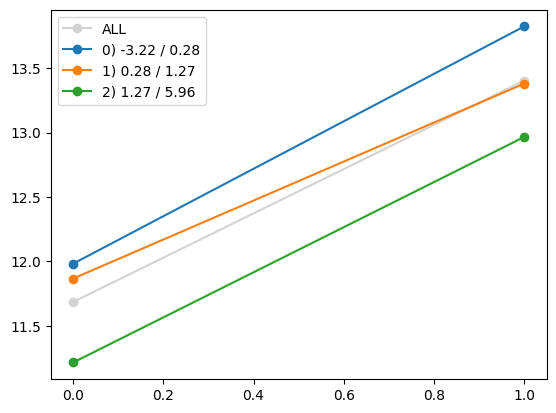

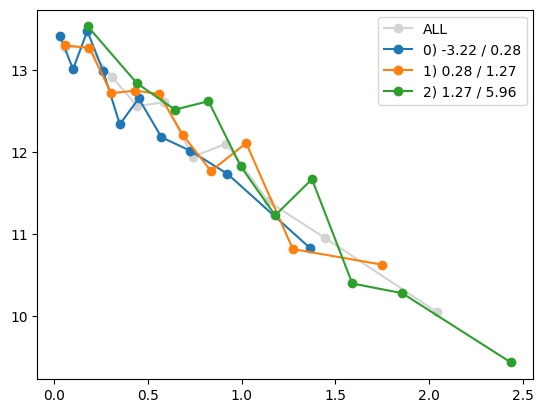

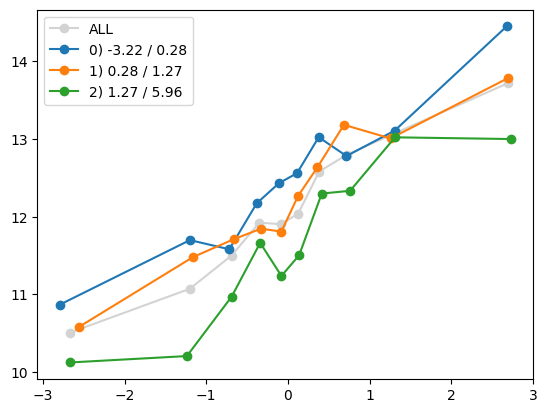

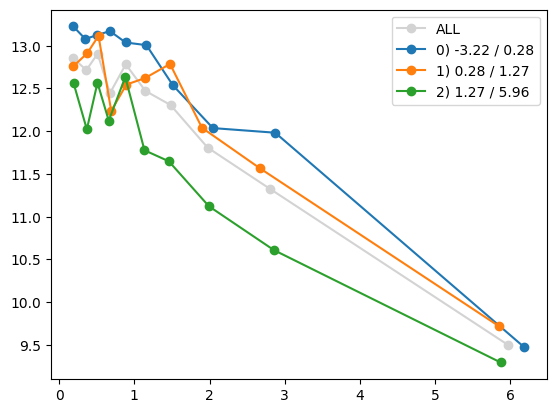

In [118]:
Xa_transformed = transform(Xa, feature_maps[1:-1])

for i in range(Xa_transformed.shape[1]):
    quantile_plot(Xa_transformed[:,i], ya, by=Xa[:,7])
    plt.show()

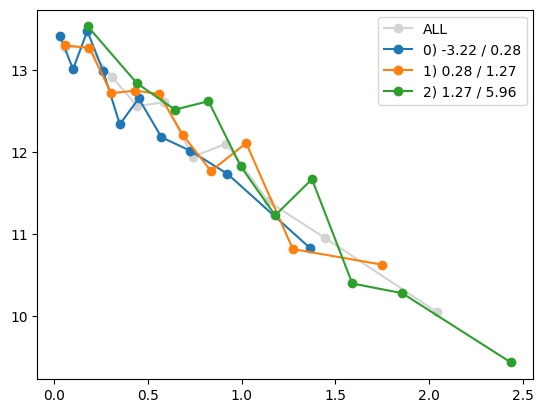

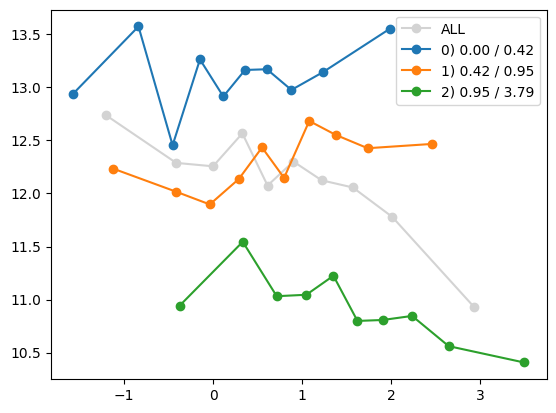

In [119]:
quantile_plot(Xa_transformed[:,4], ya, by=Xa[:,7])
plt.show()
quantile_plot(Xa[:,7], ya, by=Xa_transformed[:,4])
plt.show()

In [120]:
feature_maps = feature_maps[:-1]

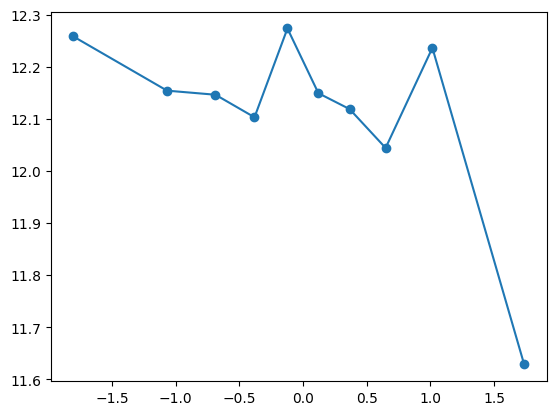

In [121]:
quantile_plot(Xa[:,8], ya)

Not sure what to do with this one. Let’s leave it till the end

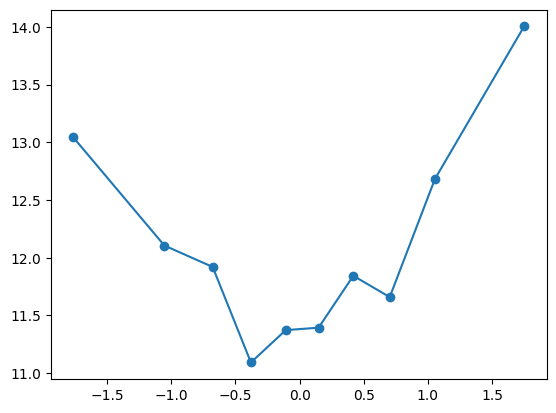

In [122]:
quantile_plot(Xa[:,9], ya)

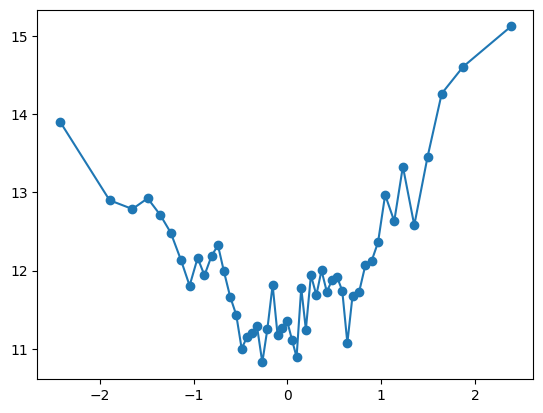

In [123]:
quantile_plot(Xa[:,9], ya, bins=50)

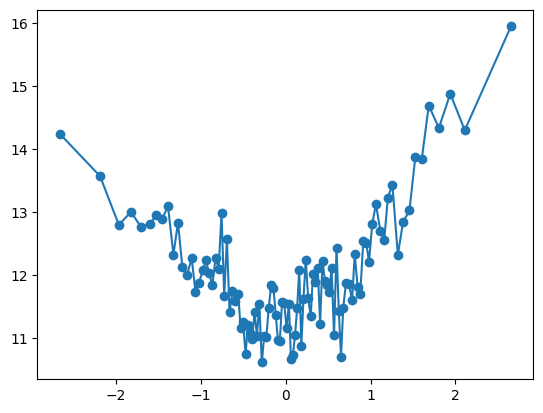

In [124]:
quantile_plot(Xa[:,9], ya, bins=100)

In [125]:
feature_maps.append(lambda X: X[:,9])
feature_maps.append(lambda X: (X[:,9] + 0.5) * (X[:,9] > -0.5))
feature_maps.append(lambda X: (X[:,9] - 0.5) * (X[:,9] > 0.5))

fit_and_evaluate(Xa, ya, Xb, yb, feature_maps)

7.318767364489894

# Interactions

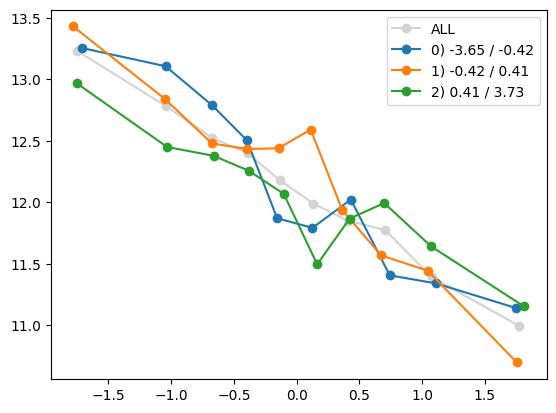

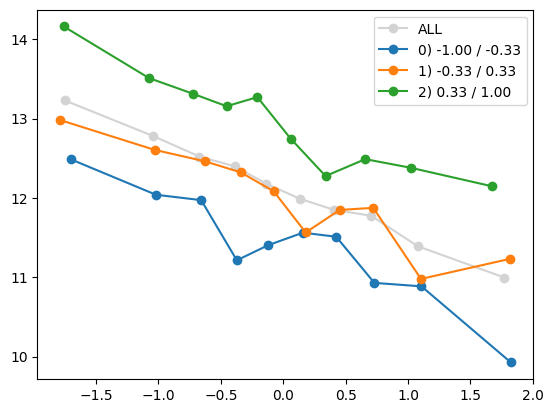

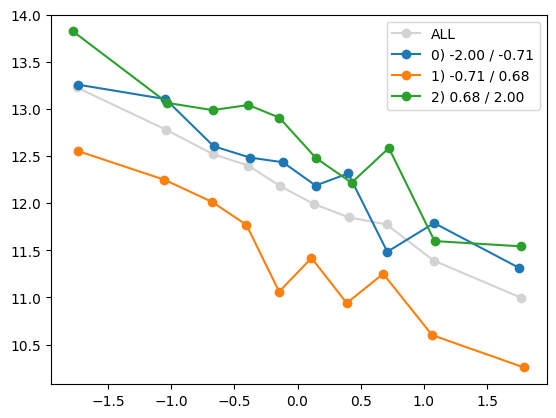

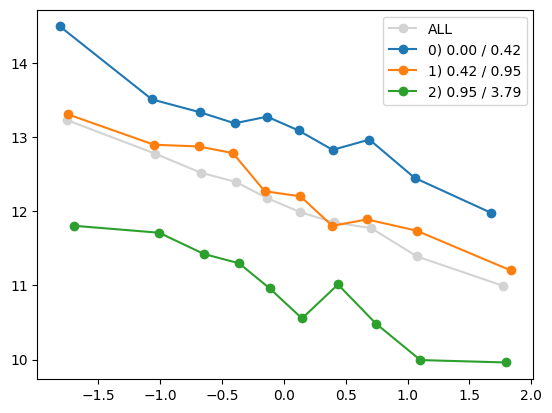

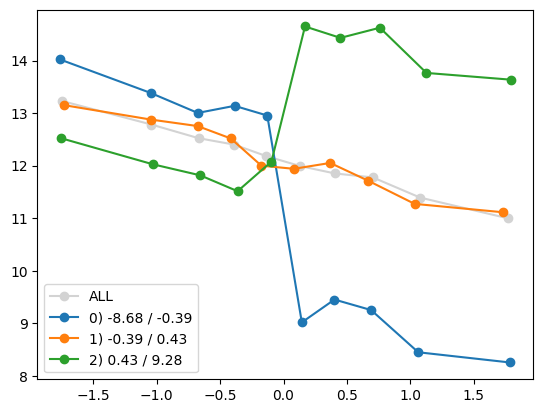

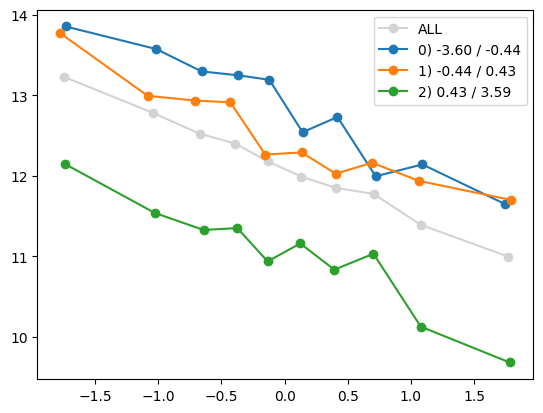

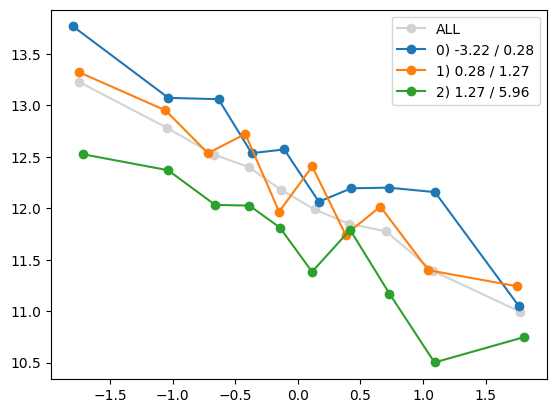

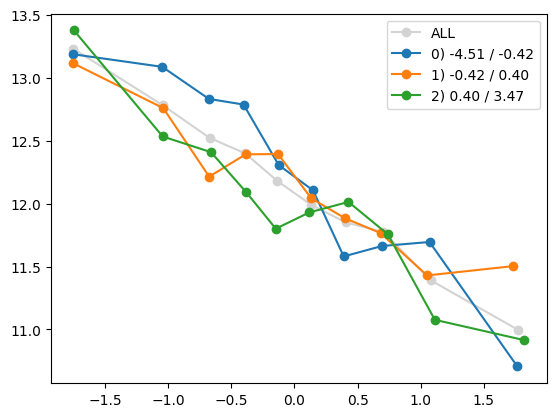

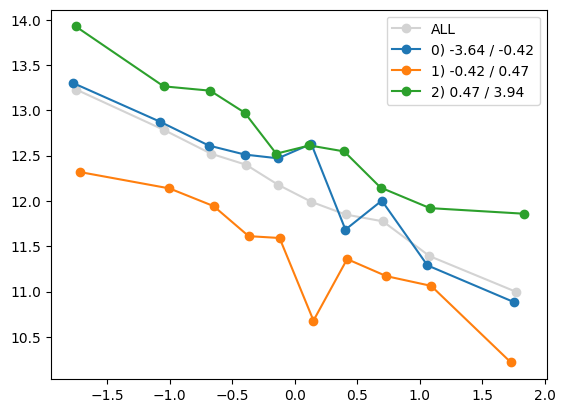

In [126]:
for i in range(1, Xa.shape[1]):
    quantile_plot(Xa[:,0], ya, by=Xa[:,i])
    plt.show()

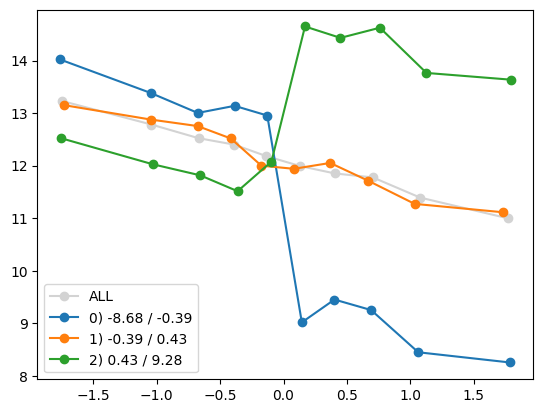

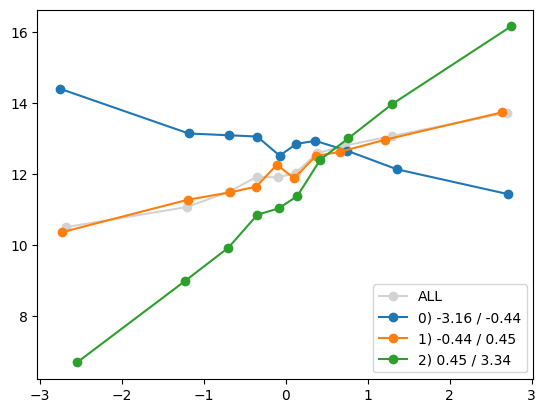

In [127]:
quantile_plot(Xa[:,0], ya, by=Xa[:,5])
plt.show()
quantile_plot(Xa[:,5], ya, by=Xa[:,0])
plt.show()

In [128]:
quantile_plot(Xa[:,5], ya, Xa[:,0], by_bins=10)

In [129]:
feature_maps.append(lambda X: X[:,5] * (X[:,0] > 0))

fit_and_evaluate(Xa, ya, Xb, yb, feature_maps)

4.469515803224729

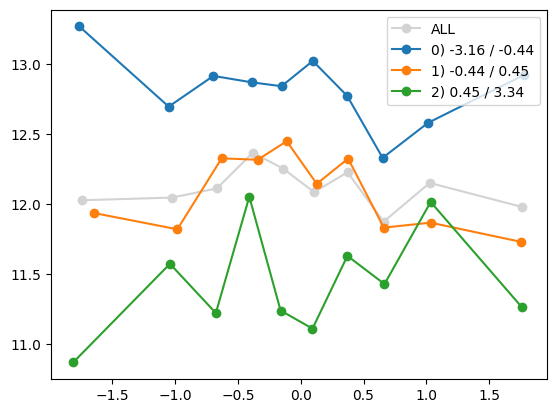

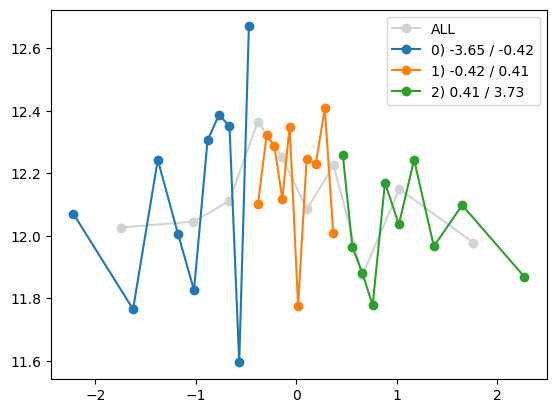

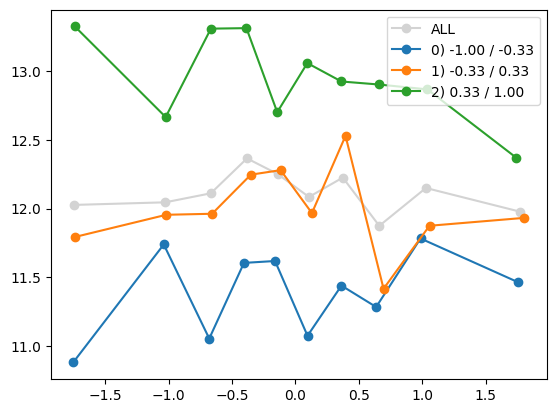

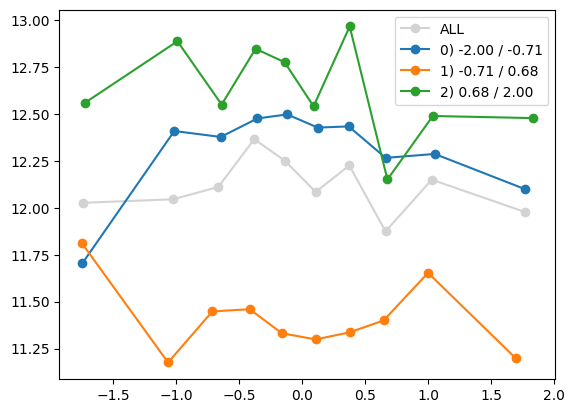

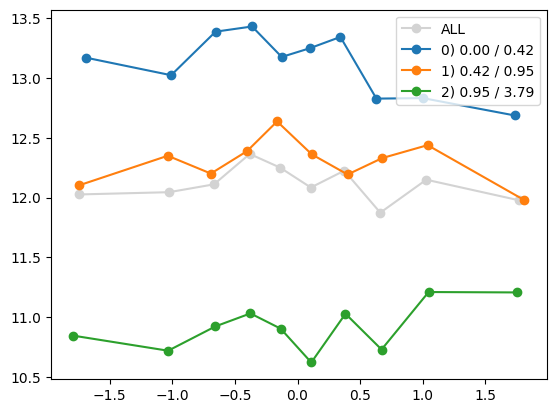

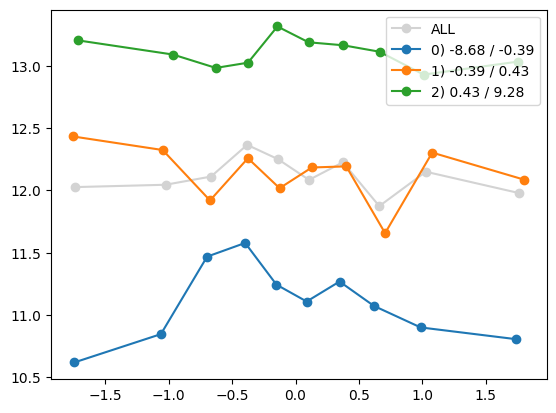

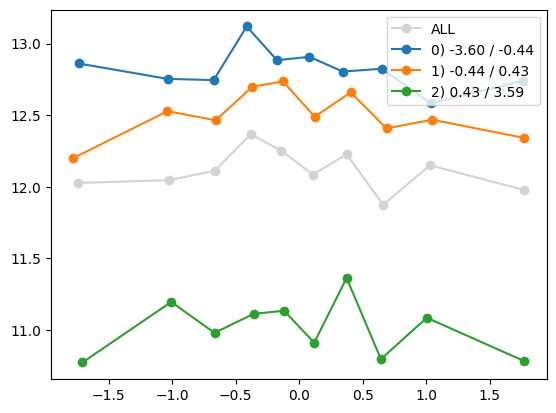

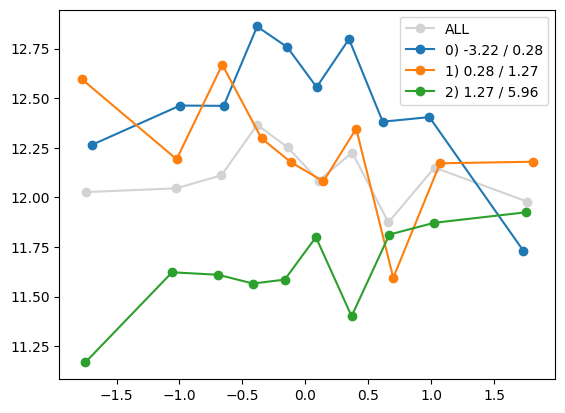

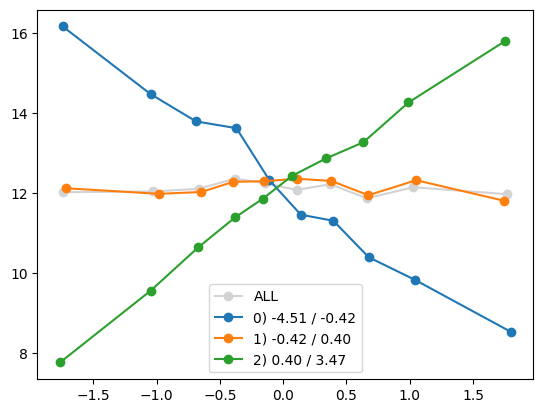

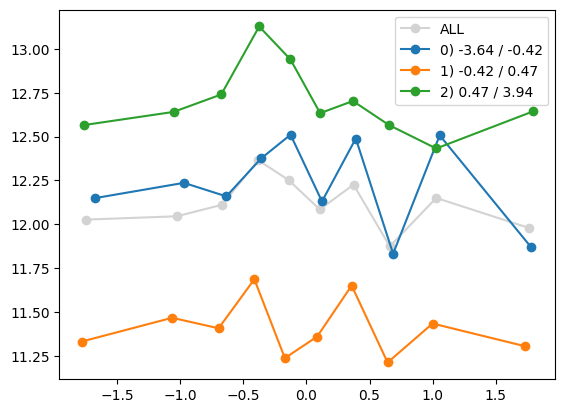

In [130]:
for i in range(Xa.shape[1]):
    quantile_plot(Xa[:,1], ya, by=Xa[:,i])
    plt.show()

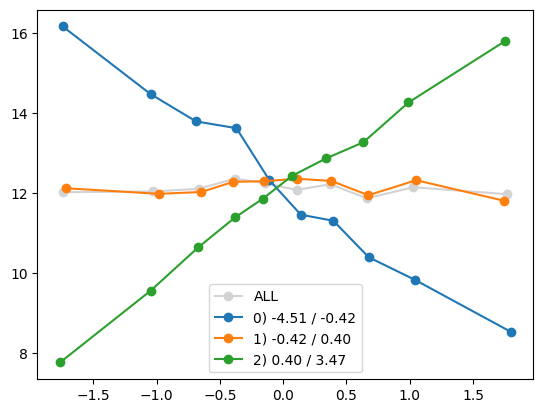

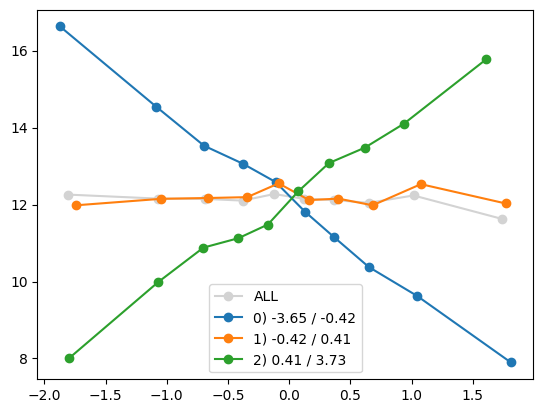

In [131]:
quantile_plot(Xa[:,1], ya, Xa[:,8])
plt.show()
quantile_plot(Xa[:,8], ya, Xa[:,1])

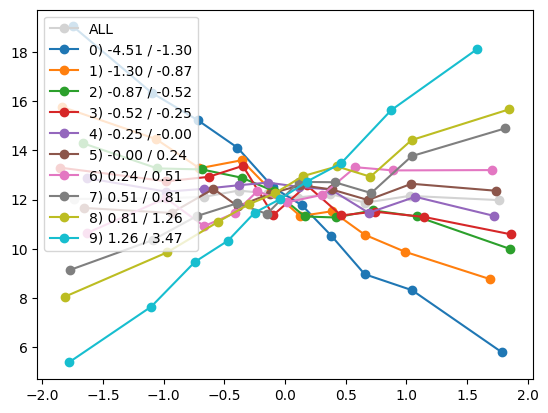

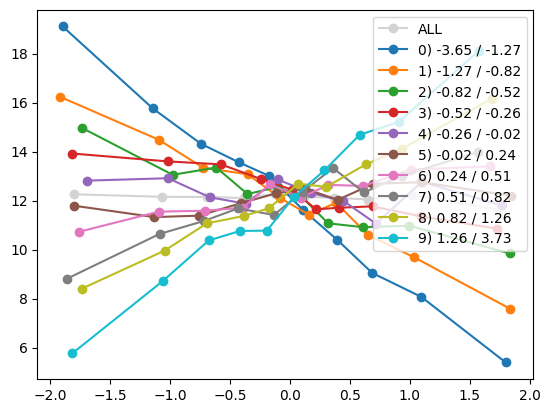

In [132]:
quantile_plot(Xa[:,1], ya, Xa[:,8], by_bins=10)
plt.show()
quantile_plot(Xa[:,8], ya, Xa[:,1], by_bins=10)

In [133]:
feature_maps.append(lambda X: X[:,1] * X[:,8])

fit_and_evaluate(Xa, ya, Xb, yb, feature_maps)

0.018292521300666345

## Are we done?